In [1]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
import sklearn
from Bio.Seq import Seq
import math
np.random.seed(42)
from transformers import TFBertModel, BertTokenizer,BertConfig
from transformers import TFT5EncoderModel, T5Tokenizer
import re


Code for ProtBERT and BFD

In [2]:
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False)
embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)

2022-12-20 23:51:48.992906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-20 23:51:48.993097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

Changes from previous version: I am implementing COVID-19 classification with ProtTrans (Rostlab models) starting with the BFD

In [3]:
def get_embeddings(sequence_list):
    # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
    # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
    sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
    ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
    input_ids = ids['input_ids']
    attention_mask = np.asarray(ids['attention_mask'])
    embedding = np.asarray(embedding_model(input_ids)[0])
    # print(embedding_model(input_ids)[0].shape)
    # print(embedding_model(input_ids)[1].shape)
    cls_embeddings = [] 
    residue_embeddings = []
    average_embeddings = []
    for seq_num in range(len(embedding)):
        cls = embedding[seq_num][0]

        seq_len = (attention_mask[seq_num] == 1).sum()
        
        # seq_len = (len(attention_mask[seq_num]))
        residues = embedding[seq_num][1:seq_len-1]
        print(np.shape(residues))
        average = np.mean(residues, axis=0)

        cls_embeddings.append(cls)
        residue_embeddings.append(residues)
        average_embeddings.append(average)

    return np.asarray(cls_embeddings), np.asarray(average_embeddings), residue_embeddings

In [4]:
sequences_Example = ["A E T C Z A O","S K T Z P"]

In [5]:
cls_embeddings, average_embeddings, residue_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

(7, 1024)
(5, 1024)


In [6]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [7]:
tf.__version__

'2.10.0'

Code for T5

In [8]:
# tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

In [9]:
# embedding_model = TFT5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50", from_pt=True)

In [10]:
# def get_embeddings(sequence_list):
#     # tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
#     # embedding_model = TFBertModel.from_pretrained("Rostlab/prot_bert_bfd", from_pt=True)
#     sequence_list = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequence_list]
#     ids = tokenizer.batch_encode_plus(sequence_list, add_special_tokens=True, padding=True, return_tensors="tf")
#     input_ids = ids['input_ids']
#     # print(input_ids)
#     attention_mask = np.asarray(ids['attention_mask'])
#     # print(attention_mask)
#     embedding = np.asarray(embedding_model(input_ids).last_hidden_state)
#     # print(embedding.shape)
#     residue_embeddings = []
#     average_embeddings = []
#     for seq_num in range(len(embedding)):

#         seq_len = (attention_mask[seq_num] == 1).sum()
        
#         # seq_len = (len(attention_mask[seq_num]))
#         residues = embedding[seq_num][:seq_len-1]
#         # print(np.shape(residues))
#         average = np.mean(residues, axis=0)

#         residue_embeddings.append(residues)
#         average_embeddings.append(average)

#     return np.asarray(average_embeddings), residue_embeddings

In [11]:
# sequences_Example = ["A E T C Z A O","S K T Z P"]

In [12]:
# average_embeddings, residue_embeddings = get_embeddings(sequences_Example)
# print(residue_embeddings)

# Data Formatting

In [13]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
5,QITLKESGPTLVKPTQTLTLTCKLSGFSVNTGGVGVGWIRQPPGKA...
32,QVQLVQSGAEVKKPGSSVKVSCKASGDTFNIYAINWVRQAPGQGLE...
33,QVQLVQSGAEVKKPGSSVKVSCKASGGTFNSYAITWVRQAPGQGLE...
34,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTHGMHWVRQAPGKGLE...
35,QVQLVQSGAEVKKPGSSVKVSCKASGGTFRRYAISWVRQAPGQGLE...
...,...
11862,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
11863,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
11864,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
11865,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [14]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11415:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11415


In [15]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

138
138


In [16]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [17]:
# from transformers import BertForMaskedLM, BertTokenizer, pipeline
# tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
# model = BertForMaskedLM.from_pretrained("Rostlab/prot_bert")
# unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)
# unmasker('D L I P T S S K L V V [MASK] D T S L Q V K K A F F A L V T')

In [18]:
# from transformers import BertModel, BertTokenizer
# import re
# tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
# model = BertModel.from_pretrained("Rostlab/prot_bert")
# sequence_Example = "A E T C Z A O"
# sequence_Example = re.sub(r"[UZOB]", "X", sequence_Example)
# encoded_input = tokenizer(sequence_Example, return_tensors='pt')
# output = model(**encoded_input)

In [19]:
covid_sequences = [(" ".join(s)) for s in covid_sequences][:int(len(covid_sequences) * 0.1)]
healthy_sequences = [(" ".join(s)) for s in healthy_sequences][:int(len(healthy_sequences) * 0.1)]

covid_cls_embeddings, covid_average_embeddings, covid_residue_embeddings = get_embeddings(covid_sequences)
healthy_cls_embeddings, healthy_average_embeddings, healthy_residue_embeddings = get_embeddings(healthy_sequences) #NOOOOOOOOOO IT WAS COVID BEFORE THAT CAUSED ALL THE MISTAKES

(122, 1024)
(120, 1024)
(122, 1024)
(120, 1024)
(124, 1024)
(117, 1024)
(125, 1024)
(129, 1024)
(121, 1024)
(126, 1024)
(124, 1024)
(121, 1024)
(119, 1024)
(116, 1024)
(126, 1024)
(119, 1024)
(118, 1024)
(122, 1024)
(121, 1024)
(127, 1024)
(115, 1024)
(118, 1024)
(124, 1024)
(125, 1024)
(124, 1024)
(122, 1024)
(118, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(121, 1024)
(123, 1024)
(127, 1024)
(122, 1024)
(121, 1024)
(121, 1024)
(118, 1024)
(127, 1024)
(118, 1024)
(129, 1024)
(117, 1024)
(129, 1024)
(117, 1024)
(124, 1024)
(125, 1024)
(127, 1024)
(121, 1024)
(127, 1024)
(127, 1024)
(125, 1024)
(121, 1024)
(121, 1024)
(126, 1024)
(128, 1024)
(123, 1024)
(120, 1024)
(131, 1024)
(117, 1024)
(124, 1024)
(127, 1024)
(117, 1024)
(128, 1024)
(128, 1024)
(124, 1024)
(126, 1024)
(123, 1024)
(130, 1024)
(119, 1024)
(127, 1024)
(125, 1024)
(120, 1024)
(120, 1024)
(121, 1024)
(124, 1024)
(124, 1024)
(123, 1024)
(128, 1024)
(127, 1024)
(120, 1024)
(120, 1024)
(117, 1024)
(119, 1024)
(128, 1024)
(120

In [20]:
healthy_lables = [0] * 1141
covid_lables = [1] * 1141

In [21]:
def pad_to_dense(M):
    """Appends the minimal required amount of zeroes at the end of each 
     array in the jagged array `M`, such that `M` looses its jagedness."""

    maxlen = max(len(r) for r in M)
    print(maxlen)
    maxlen = 135

    Z = np.zeros((len(M), maxlen, 1024))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] = row 
    return Z

In [22]:
healthy_residue_embeddings = pad_to_dense(healthy_residue_embeddings)

134


In [23]:
np.shape(healthy_residue_embeddings)

(1141, 135, 1024)

In [24]:
covid_residue_embeddings = pad_to_dense(covid_residue_embeddings)

135


In [25]:
np.shape(covid_residue_embeddings)

(1141, 135, 1024)

In [26]:
X = np.concatenate(([i for i in healthy_residue_embeddings], [i for i in covid_residue_embeddings]))
y = np.concatenate((healthy_lables, covid_lables))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Model

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(135, 1024)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  # tf.keras.layers.Dense(8, activation='relu'),
  # tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 138240)            0         
                                                                 
 dense (Dense)               (None, 1024)              141558784 
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_91 (Dropout)        (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_92 (Dropout)        (None, 128)               0

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, epochs=25, validation_data = (X_val, y_val))

Epoch 1/25


2022-12-20 23:53:10.598602: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-20 23:53:11.111743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - ETA: 0s - loss: 0.9470 - accuracy: 0.6632

2022-12-20 23:53:20.688797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


58/58 [==============================] - 10s 168ms/step - loss: 0.9470 - accuracy: 0.6632 - val_loss: 0.5565 - val_accuracy: 0.5874
Epoch 2/25
58/58 [==============================] - 5s 82ms/step - loss: 0.5539 - accuracy: 0.6946 - val_loss: 0.4960 - val_accuracy: 0.7330
Epoch 3/25
58/58 [==============================] - 6s 104ms/step - loss: 0.5045 - accuracy: 0.7206 - val_loss: 0.5115 - val_accuracy: 0.7282
Epoch 4/25
58/58 [==============================] - 6s 85ms/step - loss: 0.4978 - accuracy: 0.7250 - val_loss: 0.5010 - val_accuracy: 0.7233
Epoch 5/25
58/58 [==============================] - 5s 84ms/step - loss: 0.4973 - accuracy: 0.7244 - val_loss: 0.4953 - val_accuracy: 0.7233
Epoch 6/25
58/58 [==============================] - 5s 86ms/step - loss: 0.4963 - accuracy: 0.7250 - val_loss: 0.5003 - val_accuracy: 0.7282
Epoch 7/25
58/58 [==============================] - 5s 82ms/step - loss: 0.4655 - accuracy: 0.7369 - val_loss: 0.5112 - val_accuracy: 0.7184
Epoch 8/25
58/58 [===

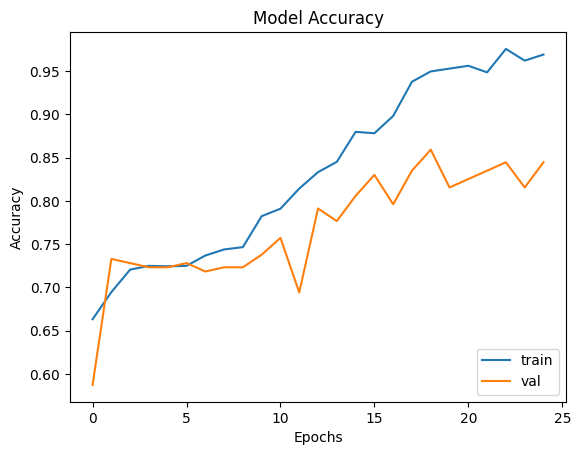

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Testing

In [32]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 63ms/step - loss: 0.3625 - accuracy: 0.8908


[0.3624858260154724, 0.8908296823501587]

In [33]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 18ms/step


2022-12-20 23:55:20.561287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([

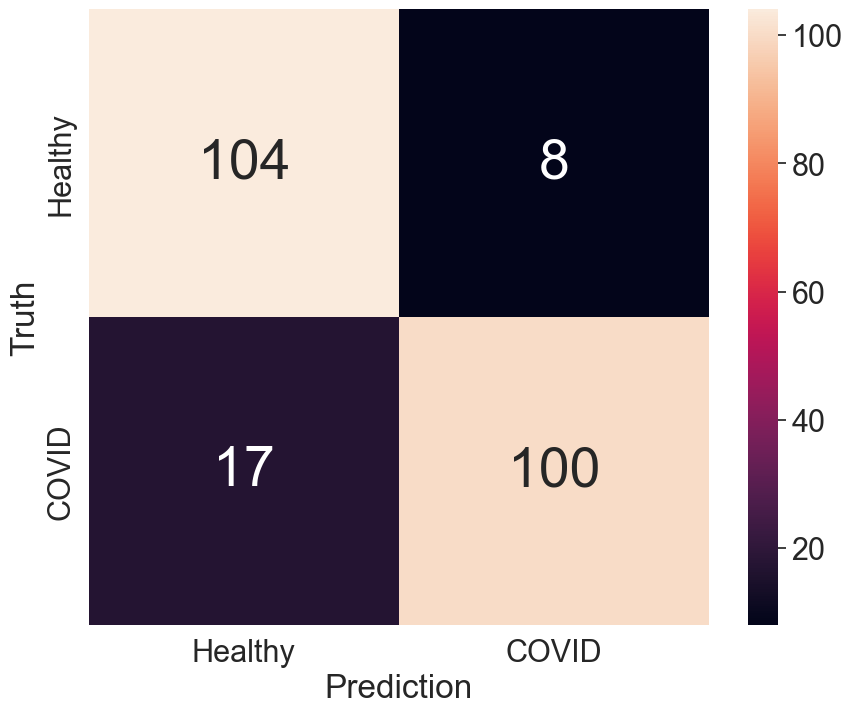

tf.Tensor(
[[104   8]
 [ 17 100]], shape=(2, 2), dtype=int32)


In [34]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [35]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

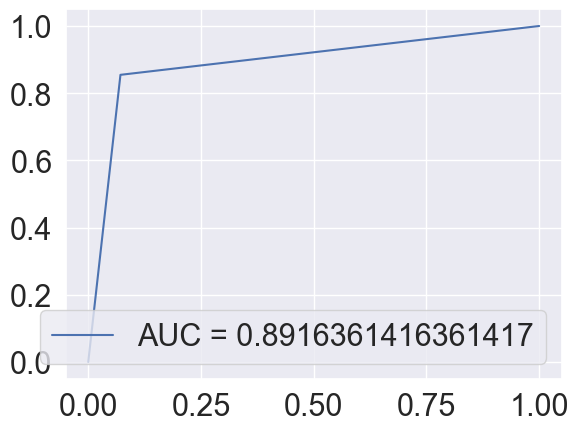

: 

In [36]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()